# GLM: Linear Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pymc3 import  *
import theano
import pandas as pd
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.tools.plotting import scatter_matrix

Simple example
==============

Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [2]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

The `glm.linear_component()` function can be used to generate the output variable y_est and coefficients of the specified linear model.

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 57.124:   9%|▉         | 18505/200000 [00:01<00:18, 9875.57it/s] 
Convergence archived at 18600
Interrupted at 18,600 [9%]: Average Loss = 98.874
100%|██████████| 2500/2500 [00:04<00:00, 506.15it/s]


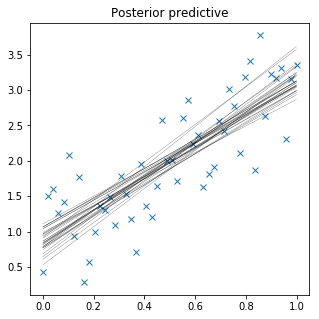

In [3]:
with Model() as model:
    lm = glm.LinearComponent.from_formula('y ~ x', data)
    sigma = Uniform('sigma', 0, 20)
    y_obs = Normal('y_obs', mu=lm.y_est, sd=sigma, observed=y)
    trace = sample(2000, njobs=2)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace)

Since there are a couple of general linear models that are being used over and over again (Normally distributed noise, logistic regression etc), the `glm.glm()` function simplifies the above step by creating the likelihood (y_obs) and its priors (sigma) for us. Since we are working in the model context, the random variables are all added to the model behind the scenes. This function also automatically finds a good starting point which it returns.

Note that the below call to `glm()` is producing exactly the same model as above, just more succinctly.

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 56.78:   7%|▋         | 13100/200000 [00:01<00:17, 10717.30it/s]
Convergence archived at 14100
Interrupted at 14,100 [7%]: Average Loss = 96.604
100%|██████████| 2500/2500 [00:05<00:00, 478.76it/s]


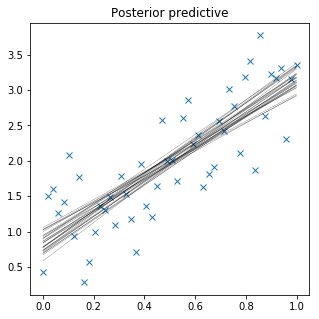

In [4]:
with Model() as model:
    GLM.from_formula('y ~ x', data)
    trace = sample(2000, njobs=2)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace)

Robust GLM
==========

Lets try the same model but with a few outliers in the data.

In [5]:
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 112.7:   5%|▍         | 9387/200000 [00:01<00:20, 9269.32it/s] 
Convergence archived at 10100
Interrupted at 10,100 [5%]: Average Loss = 172.01
100%|██████████| 2500/2500 [00:04<00:00, 514.92it/s]


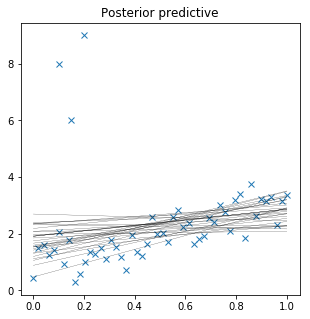

In [6]:
with Model() as model:
    GLM.from_formula('y ~ x', data_outlier)
    trace = sample(2000, njobs=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace)

Because the normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly.

Instead, we can replace the Normal likelihood with a student T distribution which has heavier tails and is more robust towards outliers. While this could be done with the `linear_compoment()` function and manually defining the T likelihood we can use the `glm()` function for more automation. By default this function uses a normal likelihood. To define the usage of a T distribution instead we can pass a family object that contains information on how to link the output to `y_est` (in this case we explicitly use the Identity link function which is also the default) and what the priors for the T distribution are. Here we fix the degrees of freedom `nu` to 1.5.

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 80.537:   5%|▌         | 10540/200000 [00:01<00:19, 9772.92it/s]
Convergence archived at 11100
Interrupted at 11,100 [5%]: Average Loss = 109.94
100%|██████████| 2500/2500 [00:06<00:00, 378.68it/s]


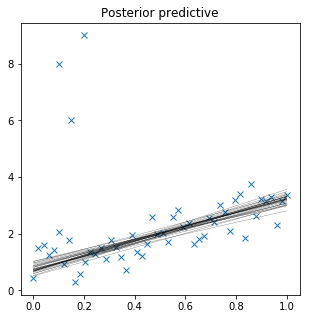

In [7]:
with Model() as model_robust:
    family = glm.families.StudentT(link=glm.families.Identity(),  
                                   priors={'nu': 1.5,
                                           'lam': Uniform.dist(0, 20)})
    GLM.from_formula('y ~ x', data_outlier, family=family)    
    trace = sample(2000, njobs=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace)

# Hierarchical GLM

In [8]:
sat_data = pd.read_csv(get_data('Guber1999data.txt'))

In [9]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_sd = Uniform('grp_sd', 0, 200)
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std()),
          'spend': Normal.dist(mu=grp_mean, sd=grp_sd),
          'stu_tea_rat': Normal.dist(mu=grp_mean, sd=grp_sd),
          'salary': Normal.dist(mu=grp_mean, sd=grp_sd),
          'prcnt_take': Normal.dist(mu=grp_mean, sd=grp_sd)
    }
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data, priors=priors)
    trace_sat = sample(2000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 270.97:  11%|█         | 22364/200000 [00:03<00:20, 8680.71it/s]   
Convergence archived at 22500
Interrupted at 22,500 [11%]: Average Loss = 29,630
 84%|████████▎ | 2092/2500 [00:43<00:07, 56.83it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 1 contains 3 diverging samples after tuning. If increasing `target_accept` doesn't help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 2495/2500 [00:51<00:00, 63.13it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` doesn't help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [00:51<00:00, 48.69it/s]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


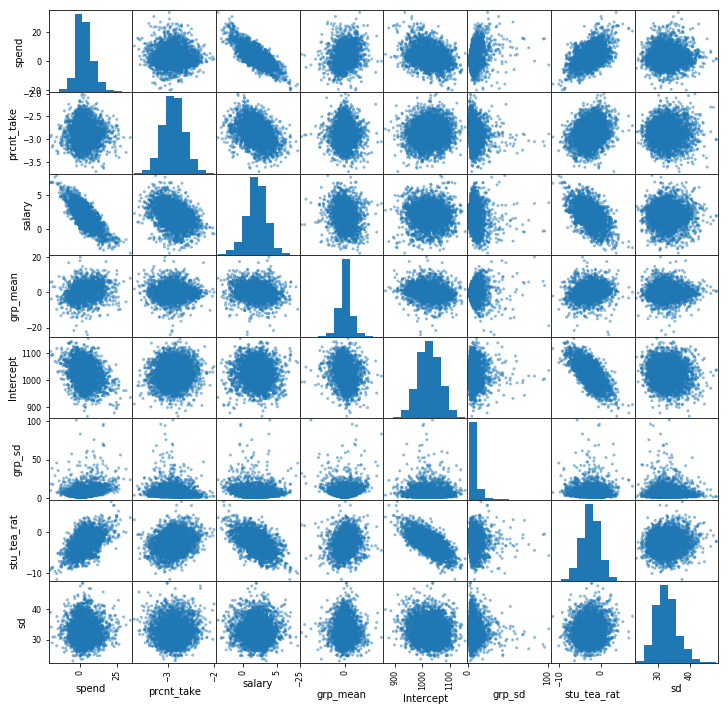

In [10]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

In [11]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_prec = Gamma('grp_prec', alpha=1, beta=.1, testval=1.)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std())
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data,
        priors={'Intercept': intercept, 'Regressor': slope})
    trace_sat = sample(2000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 266.59:  10%|▉         | 19702/200000 [00:02<00:21, 8240.22it/s]   
Convergence archived at 20100
Interrupted at 20,100 [10%]: Average Loss = 33,127
100%|██████████| 2500/2500 [00:46<00:00, 53.91it/s]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


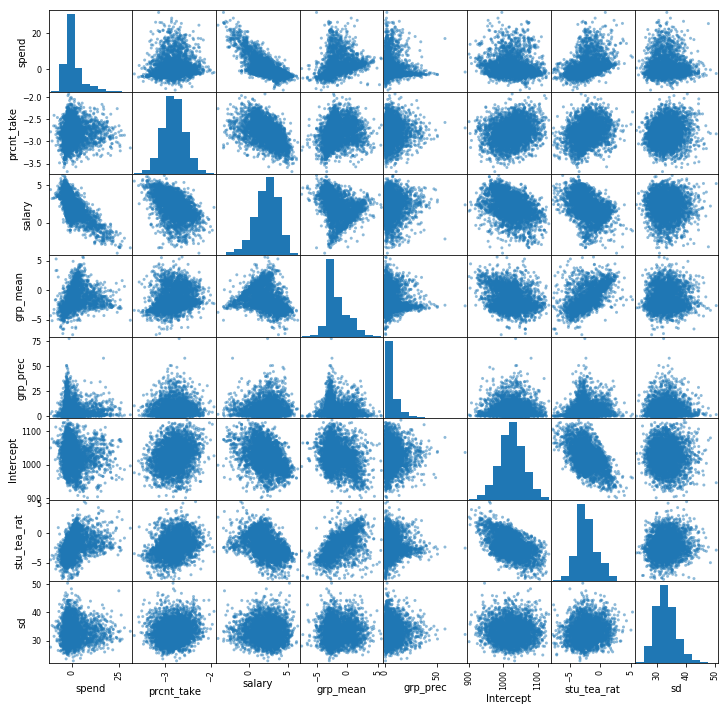

In [12]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

In [13]:
tdf_gain = 5.
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_prec = Gamma('grp_prec', alpha=1, beta=.1, testval=1.)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1) #grp_df)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sd=sat_data.sat_t.std())
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data,
                priors={'Intercept': intercept, 'Regressor': slope})

    trace_sat = sample(2000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 266.58:  10%|▉         | 19977/200000 [00:03<00:28, 6292.44it/s]   
Convergence archived at 20100
Interrupted at 20,100 [10%]: Average Loss = 33,127
100%|██████████| 2500/2500 [00:45<00:00, 55.08it/s]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


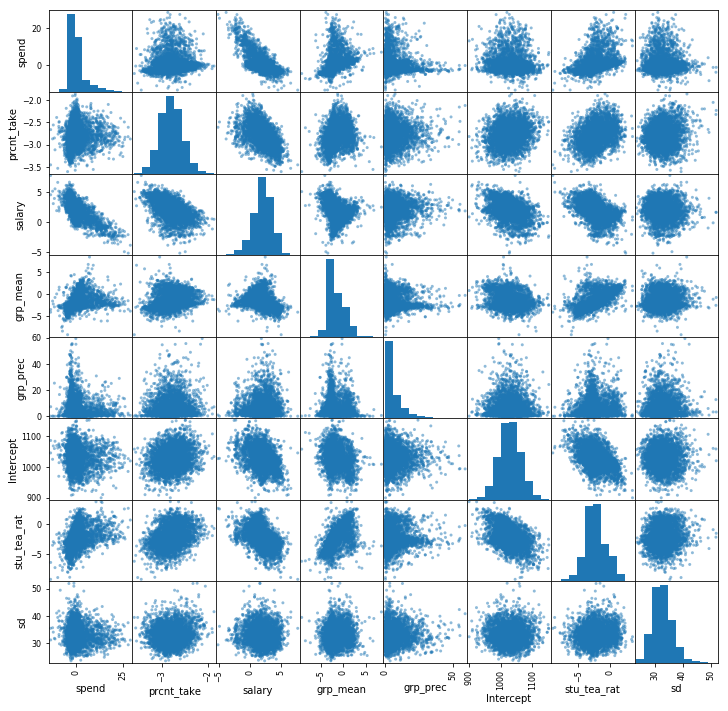

In [14]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

# Logistic Regression

In [15]:
htwt_data = pd.read_csv(get_data('HtWt.csv'))
htwt_data.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [16]:
m = glm_sm('male ~ height + weight', htwt_data, family=sm.families.Binomial()).fit()
print(m.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   male   No. Observations:                   70
Model:                            GLM   Df Residuals:                       67
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -28.298
Date:                Tue, 30 May 2017   Deviance:                       56.597
Time:                        15:14:11   Pearson chi2:                     62.8
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.2059     10.887     -4.152      0.000     -66.545     -23.867
height         0.6571      0.164      4.018      0.0

In [17]:
with Model() as model_htwt:
    GLM.from_formula('male ~ height + weight', htwt_data, family=glm.families.Binomial())
    trace_htwt = sample(2000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 528.1:   6%|▌         | 11629/200000 [00:01<00:20, 9049.29it/s]  
Convergence archived at 11700
Interrupted at 11,700 [5%]: Average Loss = 1,513.3
 93%|█████████▎| 2313/2500 [02:50<00:10, 17.84it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|█████████▉| 2499/2500 [03:03<00:00, 11.60it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████| 2500/2500 [03:03<00:00, 13.63it/s]


                mean        std        min        25%        50%        75%  \
height      0.714955   0.166707   0.290146   0.597691   0.709490   0.823537   
weight      0.010473   0.011286  -0.026680   0.002675   0.010263   0.017928   
Intercept -49.197308  11.099544 -97.695082 -56.375218 -48.850502 -41.635109   

                 max  
height      1.467539  
weight      0.060969  
Intercept -22.206624  


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


P(weight < 0) =  0.181
P(height < 0) =  0.0


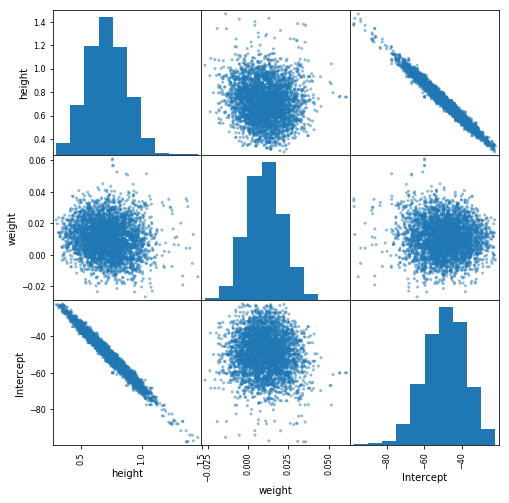

In [18]:
trace_df = trace_to_dataframe(trace_htwt)
print(trace_df.describe().drop('count').T)
scatter_matrix(trace_df, figsize=(8, 8))
print("P(weight < 0) = ", (trace_df['weight'] < 0).mean())
print("P(height < 0) = ", (trace_df['height'] < 0).mean())

## Bayesian Logistic Lasso

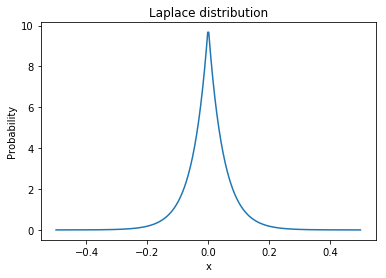

In [19]:
lp = Laplace.dist(mu=0, b=0.05)
x_eval = np.linspace(-.5, .5, 300)
plt.plot(x_eval, theano.tensor.exp(lp.logp(x_eval)).eval())
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Laplace distribution');

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 618.18:   5%|▌         | 10391/200000 [00:00<00:12, 14898.77it/s]
Convergence archived at 11700
Interrupted at 11,700 [5%]: Average Loss = 1,506.1
100%|██████████| 1000/1000 [00:35<00:00, 25.74it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)

/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  if sys.path[0] == '':


                mean       std        min        25%        50%        75%  \
height      0.348405  0.089288   0.027613   0.286484   0.347560   0.409454   
weight      0.011833  0.009546  -0.015049   0.005789   0.011137   0.017528   
Intercept -25.002341  5.917234 -44.146572 -29.108058 -25.044936 -20.806721   

                max  
height     0.632673  
weight     0.049499  
Intercept -4.222934  


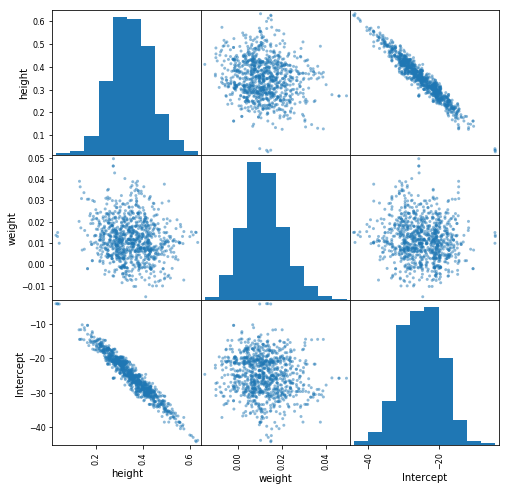

In [20]:
with Model() as model_lasso:
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=0, sd=50),
              'Regressor': Laplace.dist(mu=0, b=0.05)
    }
    GLM.from_formula('male ~ height + weight', htwt_data, family=glm.families.Binomial(),
                    priors=priors)
    
    trace_lasso = sample(500, njobs=2)
    
trace_df = trace_to_dataframe(trace_lasso)
scatter_matrix(trace_df, figsize=(8, 8));
print(trace_df.describe().drop('count').T)